In [139]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
#import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
# sys.path.insert(0, os.chdir(".."))
# from SpectralMixture import SpectralMixture, initialize_from_emp_spec
# import toolbox as t
# from bnqdflow import models, base, effect_size_measures, util, analyses
# sns.set(style='whitegrid')

### Load in data

In [140]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

    
def plot_data(x, x1, x2, y, y1, y2, b, fs):
    # plot unprocessed data
    fig, ax = plt.subplots(3,2, figsize=(24,10))
    ax[0,0].plot(x1, y1)
    ax[0,0].set_title('control heartbeat')
    ax[1,0].plot(x2, y2)
    ax[1,0].set_title('intervention heartbeat')
    ax[2,0].plot(x, y)
    ax[2,0].axvline(x=b, color='black')
    ax[2,0].set_title('Control and intervention data')

    # Plot periodogram
    freqs, Pxx = periodogram(x=y1, fs=fs)
    ax[0,1].plot(freqs, Pxx, color='blue')
    ax[0,1].set_title('Control periodogram')
    freqs, Pxx = periodogram(x=y2, fs=fs)
    ax[1,1].plot(freqs, Pxx, color='green')
    ax[1,1].set_title('Intervention periodogram')
    freqs, Pxx = periodogram(x=y, fs=fs)
    ax[2,1].plot(freqs, Pxx,color='grey')
    ax[2,1].set_title('Control and intervention Periodogram')
    plt.show()


In [168]:
# Read records of a given dataset

# for now look only at patient VP02
patients = np.array(['14'])
records = []

# Read in starting times of movie clips
for p in patients:
    with open('datasets/electrocardiogram-skin-conductance-and-respiration-from-spider-fearful-individuals-watching-spider-video-clips-1.0.0/VP'+p+'/Triggers.txt', 'r') as file:
        for i, line in enumerate(file):
            if i==0:
                continue # time of demo clip
            (name, start, end) = line.strip().split()
            records.append((int(start),int(end)))

records = np.array(records)
print(f'records: {records}\n\n')
record = '02'
fs = 100
X, Y = load_data(record)
start_time = records[0,0]
n = 2000
end_time   = records[6,1]

time_before_intervention = start_time - X[0]
#print(X[34029]) value of first spider video clip

start_index = np.where(X<=records[0][0]+2)[0]
start_index = np.where(X>= records[0][0]-2)
print(start_index)
b = X[start_index]
plt.figure(figsize=(14,10))

x  = np.linspace(X[start_index-int(n/2)], X[start_index+int(n/2)],len(Y[start_index-int(n/2):start_index+int(n/2)]))
x1 = np.linspace(X[start_index-int(n/2)], X[start_index],len(Y[start_index-int(n/2):start_index])) 
x2 = np.linspace(X[start_index], X[start_index+int(n/2)],len(Y[start_index:start_index+int(n/2)])) 

y  = Y[start_index-int(n/2):start_index+int(n/2)]
y1 = Y[start_index-int(n/2):start_index]
y2 = Y[start_index:start_index+int(n/2)]
# x, x1, x2 = np.array(x), np.array(x1), np.array(x2)
# y, y1, y2 = np.array(y), np.array(y1), np.array(y2)
print(x.shape, x1.shape,x2.shape)
print(y.shape, y1.shape, y2.shape)


sns.set(style='whitegrid')
plot_data(x, x1, x2, y, y1, y2, b, fs)

records: [[162216 162316]
 [162337 162437]
 [162453 162554]
 [162608 162709]
 [162753 162854]
 [162918 163018]
 [163034 163135]
 [163200 163301]
 [163439 163539]
 [163557 163658]
 [163723 163823]
 [163841 163942]
 [164009 164110]
 [164128 164229]
 [164247 164348]
 [164404 164505]
 [161914 164525]
 [164646 165147]]


(array([], dtype=int64),)


TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

<Figure size 1008x720 with 0 Axes>

(2000,)
(1000,) 1000


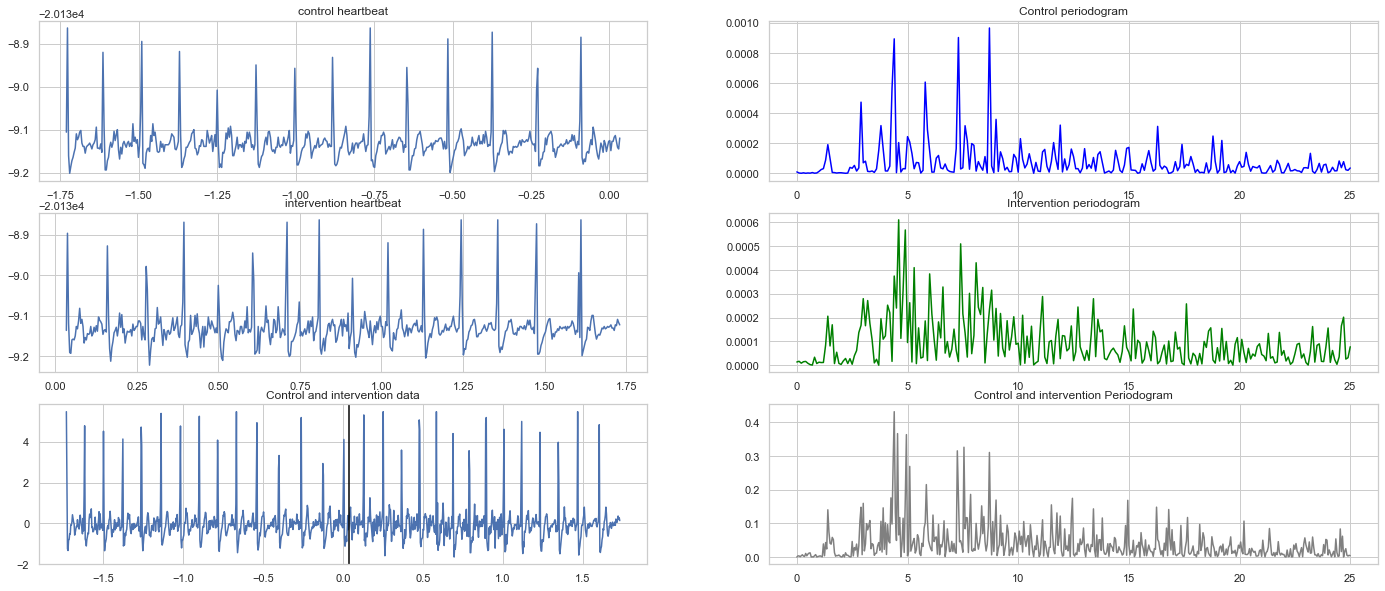

In [142]:
# Apply triangular smoothing window, and downsample to 33.3 Hz
degree = 1
y = np.array(smoothTriangle(y, degree))
print(y.shape)

step_down = 2
y, y1, y2 = y[np.arange(int(n))%step_down==0], y1[np.arange(int(n/2))%step_down==0], y2[np.arange(int(n/2))%step_down==0]
x, x1, x2 = x[np.arange(int(n))%step_down==0], x1[np.arange(int(n/2))%step_down==0], x2[np.arange(int(n/2))%step_down==0]

n = int(n/step_down)
fs = fs / step_down
print(y.shape, n)

# Standardize data
zscorey = lambda m: (m - np.mean(y)) / np.std(y)
zscorex = lambda n: (n - np.mean(x)) / np.std(x)
μ_x, σ_x = np.mean(x), np.std(x)
μ_y, σ_y = np.mean(y), np.std(y)
norm = [μ_x, μ_y, σ_x, σ_y]
b = zscorex(b)
x1= zscorex(x1)
x2= zscorex(x2)
y1= zscorex(y1)
y2= zscorex(y2)

y = zscorey(y)
x = zscorex(x)

plot_data(x, x1, x2, y, y1, y2, b, fs)
        
